In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [6]:
df = pd.read_csv('predictive_maintenance.csv')
# Rename columns by replacing spaces with underscores
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('[', '')
df.columns = df.columns.str.replace(']', '')
df.head()


,UDI,Product_ID,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Target,Failure_Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UDI                    10000 non-null  int64  
 1   Product_ID             10000 non-null  object 
 2   Type                   10000 non-null  object 
 3   Air_temperature_K      10000 non-null  float64
 4   Process_temperature_K  10000 non-null  float64
 5   Rotational_speed_rpm   10000 non-null  int64  
 6   Torque_Nm              10000 non-null  float64
 7   Tool_wear_min          10000 non-null  int64  
 8   Target                 10000 non-null  int64  
 9   Failure_Type           10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


# EDA

In [8]:
df.describe

<bound method NDFrame.describe of         UDI Product_ID Type  Air_temperature_K  Process_temperature_K  \
0         1     M14860    M              298.1                  308.6   
1         2     L47181    L              298.2                  308.7   
2         3     L47182    L              298.1                  308.5   
3         4     L47183    L              298.2                  308.6   
4         5     L47184    L              298.2                  308.7   
...     ...        ...  ...                ...                    ...   
9995   9996     M24855    M              298.8                  308.4   
9996   9997     H39410    H              298.9                  308.4   
9997   9998     M24857    M              299.0                  308.6   
9998   9999     H39412    H              299.0                  308.7   
9999  10000     M24859    M              299.0                  308.7   

      Rotational_speed_rpm  Torque_Nm  Tool_wear_min  Target Failure_Type  
0            

In [9]:
cat_cols = ['Type', 'Failure_Type']

df.select_dtypes('object').nunique()

Product_ID      10000
Type                3
Failure_Type        6
dtype: int64

/tmp/ipykernel_235724/2852668786.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'No Failure'),
 Text(1, 0, 'Power Failure'),
 Text(2, 0, 'Tool Wear Failure'),
 Text(3, 0, 'Overstrain Failure'),
 Text(4, 0, 'Random Failures'),
 Text(5, 0, 'Heat Dissipation Failure')]

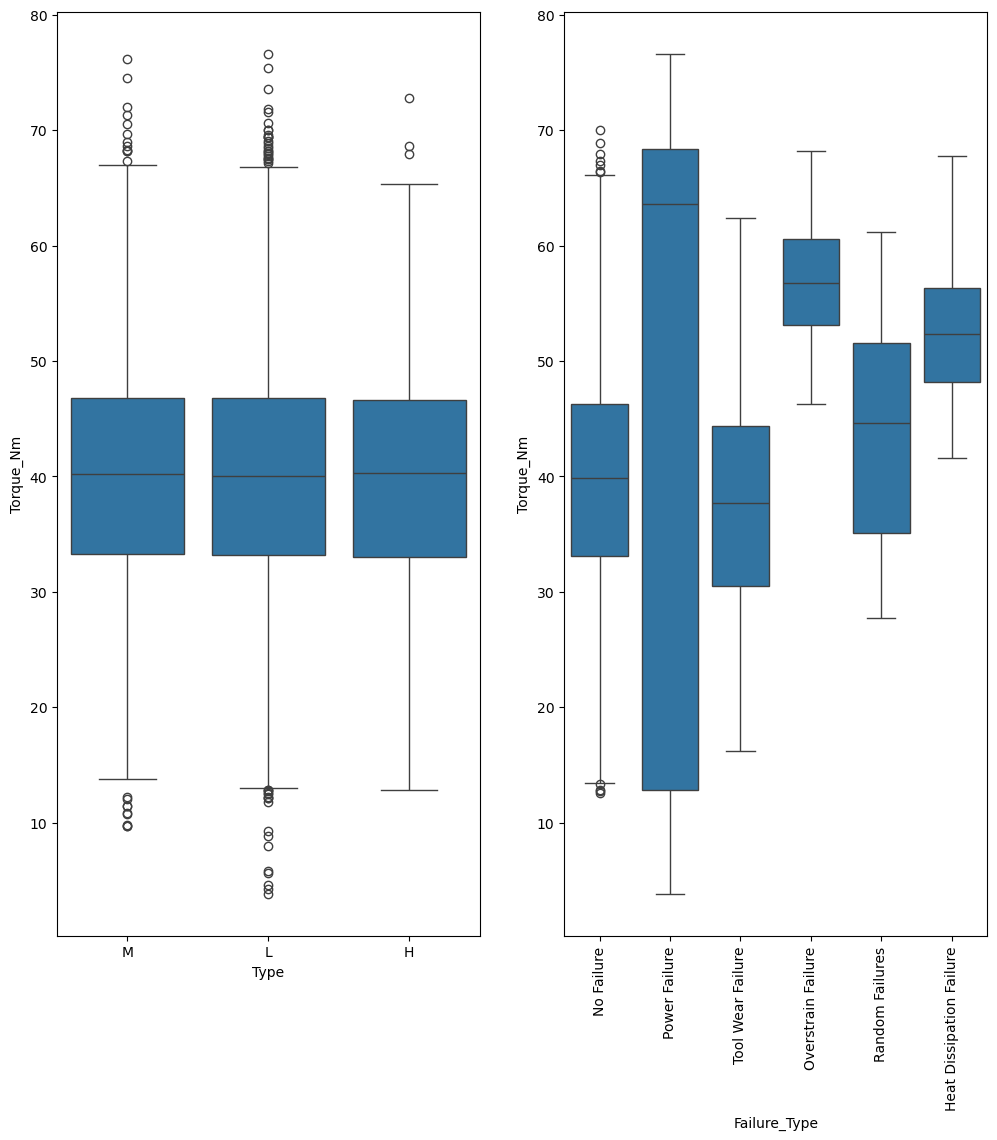

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12,12))

sns.boxplot(x=cat_cols[0], y='Torque_Nm', data=df, ax=axes[0])
g = sns.boxplot(x=cat_cols[1], y='Torque_Nm', data=df, ax=axes[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)

<Axes: xlabel='Failure_Type'>

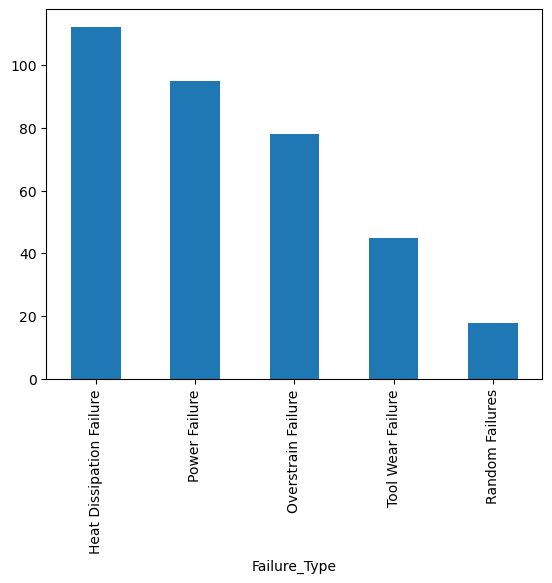

In [11]:
df.Failure_Type[df.Failure_Type != 'No Failure'].value_counts().plot(kind='bar')

# Training

In [61]:
# rename cols
X = df.drop('Failure_Type', axis=1)
y = pd.DataFrame(df['Failure_Type'])

cat_cols = list(X.dtypes[X.dtypes == 'object'].keys())
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
X_train[cat_cols] = X_train[cat_cols].apply(lambda row: row.astype('category'))
X_valid[cat_cols] = X_valid[cat_cols].apply(lambda row: row.astype('category'))
sample_row = X.loc[0].to_dict()


In [13]:
y.value_counts()

Failure_Type            
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [26]:
print(cat_cols)

['Product_ID', 'Type']


In [68]:
# cat_pipeline = Pipeline(steps=[
#     ('astype', FunctionTransformer(lambda X: X.astype('category')))
# ])

# preprocessing = ColumnTransformer(transformers=[
#     ('cat_pipeline', cat_pipeline, cat_cols),
#     ],remainder='passthrough'
# )

model = LGBMClassifier()

# pipeline = Pipeline(steps=[
#     ('transformer', preprocessing),
#     ('model', model)
# ])
# pipeline.fit(X_train, y_train)
# pipeline.fit(X_train, y_train, model__categorical_feature=cat_cols)
# pipeline.fit_transform(X_train)
# preds = pipeline.predict(X_valid)

model.fit(X_train, y_train)
preds = model.predict(X_valid)

print(f'accuracy_score: {accuracy_score(y_valid, preds)}')

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 9
[LightGBM] [Info] Start training from score -4.446946
[LightGBM] [Info] Start training from score -0.036516
[LightGBM] [Info] Start training from score -4.921840
[LightGBM] [Info] Start training from score -4.590986
[LightGBM] [Info] Start training from score -6.214608
[LightGBM] [Info] Start training from score -5.357158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.97      1.00      0.98        30
              No Failure       1.00      1.00      1.00      2903
      Overstrain Failure       0.89      0.89      0.89        27
           Power Failure       0.83      1.00      0.91        24
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.80      0.67      0.73        12

                accuracy                           0.99      3000
               macro avg       0.75      0.76      0.75      3000
            weighted avg       0.99      0.99      0.99      3000



/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Heat Dissipation Failure'),
  Text(1, 0, 'No Failure'),
  Text(2, 0, 'Overstrain Failure'),
  Text(3, 0, 'Power Failure'),
  Text(4, 0, 'Random Failures'),
  Text(5, 0, 'Tool Wear Failure')])

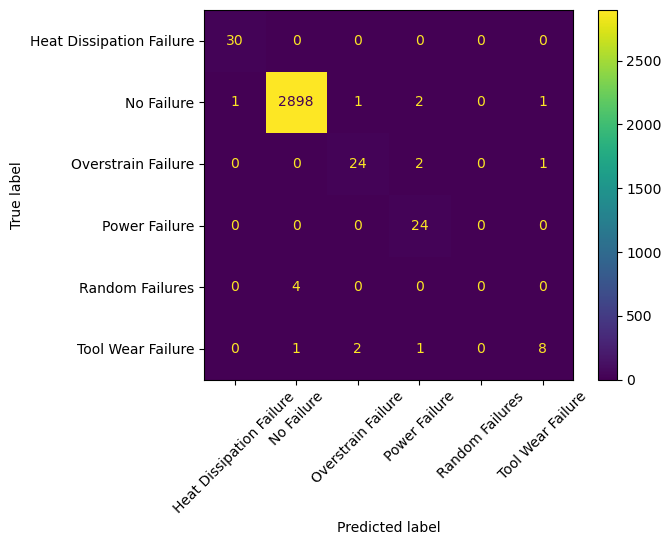

In [9]:
cm = confusion_matrix(y_valid, preds)
labels = sorted(list(y_valid['Failure_Type'].unique()))
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
print(classification_report(y_valid, preds))
plt.xticks(rotation=45)

# Optuna

In [75]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    clf = LGBMClassifier(n_estimators=n_estimators, random_state=0)
    clf.fit(X_train, y_train)
    return clf.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

model_params_list = ['n_estimators', 'boosting_type']
model_params = dict()
for value, key in study.best_trial.params.items():
    if key in model_params_list:
        model_params[key] = value

model = LGBMClassifier(**model_params)
model.fit(X_train, y_train)



[I 2024-10-11 14:50:14,333] A new study created in memory with name: no-name-c25cd477-16e0-436e-b0cf-ce5cee9fdab2


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 9
[LightGBM] [Info] Start training from score -4.446946
[LightGBM] [Info] Start training from score -0.036516
[LightGBM] [Info] Start training from score -4.921840
[LightGBM] [Info] Start training from score -4.590986
[LightGBM] [Info] Start training from score -6.214608
[LightGBM] [Info] Start training from score -5.357158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-10-11 14:50:15,056] Trial 0 finished with value: 0.9946666666666667 and parameters: {'n_estimators': 368}. Best is trial 0 with value: 0.9946666666666667.
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 9
[LightGBM] [Info] Start training from score -4.446946
[LightGBM] [Info] Start training from score -0.036516
[LightGBM] [Info] Start training from score -4.921840
[LightGBM] [Info] Start training from score -4.590986
[LightGBM] [Info] Start training from score -6.214608
[LightGBM] [Info] Start training from score -5.357158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-10-11 14:50:15,647] Trial 1 finished with value: 0.9946666666666667 and parameters: {'n_estimators': 273}. Best is trial 0 with value: 0.9946666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-11 14:50:16,078] Trial 2 finished with value: 0.9946666666666667 and parameters: {'n_estimators': 136}. Best is trial 0 with value: 0.9946666666666667.
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 9
[LightGBM] [Info] Start training from score -4.446946
[LightGBM] [Info] Start training from score -0.036516
[LightGBM] [Info] Start training from score -4.921840
[LightGBM] [Info] Start training from score -4.590986
[LightGBM] [Info] Start training from score -6.214608
[LightGBM] [Info] Start training from score -5.357158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

LGBMClassifier()

In [76]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)



In [77]:
from pydantic import BaseModel, ValidationError

class Machine(BaseModel):
    UDI: int
    Product_ID: object
    Type: object
    Air_temperature_K: float
    Process_temperature_K: float
    Rotational_speed_rpm: int
    Torque_Nm: float
    Tool_wear_min: int
    Target: int

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print(sample_row)
machine = Machine(**sample_row)
inputs = pd.DataFrame([machine.model_dump()])
inputs[cat_cols] =  inputs[cat_cols].apply(lambda row: row.astype('category')) 
pred = loaded_model.predict(inputs)[0]
pred


{'UDI': 1, 'Product_ID': 'M14860', 'Type': 'M', 'Air_temperature_K': 298.1, 'Process_temperature_K': 308.6, 'Rotational_speed_rpm': 1551, 'Torque_Nm': 42.8, 'Tool_wear_min': 0, 'Target': 0}


'No Failure'

In [78]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        machine = Machine(**request.json)
        inputs = pd.DataFrame([machine.model_dump()])
        inputs[cat_cols] =  inputs[cat_cols].apply(lambda row: row.astype('category')) 
        pred = loaded_model.predict(inputs)[0]
        response = {
            'prediction': pred
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 14:50:31] "POST /predict HTTP/1.1" 200 -
